# Benders decomposition using Julia

Problem

$min c_1^T x + c_2^T y$ <br>
s.t. <br>
$A_1 x + A_2 y \leq b$ <br>
$x \geq 0 $ <br>
$y \geq 0 $ <br>
$x \in \mathbb{Z}^n $

Master Problem 

$\min c_1^T x + \alpha $ <br>
s.t. <br>
$x \geq 0 $ <br>
$\alpha \geq \alpha^{(k)} + - \lambda^{(k),T} A_1 (x - x^{(k)})$

Sub Problem  

$\alpha = \min c_2^T y$ <br>
s.t. <br>
$A_2 y \leq b - A_1 x : [\lambda]$ <br>
$y \geq 0 $ <br>

### Example


$\min x_1 + 4 x_2 + 2 y_1 + 3 y_2 $ <br>
s.t. <br>
$ x_1 - 3 x_2 + y_1 - 2 y_2 \leq 2$ <br>
$ x_1 - 2 x_2 - y_1 - y_2 \leq 3$ <br>
$x, y \geq 0 $ 
$x \in \mathbb{Z}^n $

# separating master + sub problem 

Master Problem 

$\min x_1 + 4 x_2 + \alpha $ <br>
s.t. <br>
$x \geq 0 $ <br>
$\alpha \geq - M$

Sub Problem  

$\alpha = \min 2 y_1 + 3 y_2$ <br>
s.t. <br>
$ x_1 - 3 x_2 + y_1 - 2 y_2 \leq  - 2: [\lambda_1]$ <br>
$ -x_1 - 2 x_2 - y_1 - y_2  \leq - 3: [\lambda_2]$ <br>
$x, y \geq 0 $ 
$x \in \mathbb{Z}^n $$y \geq 0 $ <br>

In [1]:
using JuMP, GLPK

In [2]:
using Printf, Plots

In [3]:
## Parameters
c1 = [1,4]
c2 = [2,3]
A1 = [1 -3; -1 -3] # x coefficients
A2 = [1 -2; -1 -1]
b = [-2; -3]
M = -1000;

In [4]:
## Modeling the master problem  --> checking the problem use> print(master)
master = Model(GLPK.Optimizer)
@variable(master, x[1:2] ≥ 0, Int)
@variable(master, α ≥ M)
@objective(master, Min, c1'*x + α);

In [5]:
## Modeling the sub problem -- modeling inside a function
function subp(x_fixed)
    # building subproblem model
    sub = Model(GLPK.Optimizer)
    @variable(sub, y[1:2] ≥ 0)
    @objective(sub, Min, c2'*y)
    @constraint(sub, A1*x_fixed + A2*y .≤ b)
    optimize!(sub)
    
    #calling values of the solved subproblem
    o = objective_value(sub)
    y = value.(y)
    all_con = all_constraints(sub, AffExpr, MOI.LessThan{Float64})
    λ = dual.(all_con)
    
    return Dict('o' => o, 'y' => y, 'λ' => λ)
end


subp (generic function with 1 method)

In [6]:
subp([0,0])

Dict{Char, Any} with 3 entries:
  'λ' => [-0.333333, -2.33333]
  'y' => [1.33333, 1.66667]
  'o' => 7.66667

In [7]:
function print_iteration(k, args...)
    f(x) = Printf.@sprintf("%12.4e",x)
    println(lpad(k,9), " ",join(f.(args), " "))
    return
end

print_iteration (generic function with 1 method)

## Objective function of the original problem 
$ c_1^T x + c_2^T y$ <br>
Lower bound: $ c_1^T x^{(k)} + \alpha^{(k)}$ <br>
Upper bound: $ c_1^T x^{(k)} + c_2^T y^{(k)}$ 


## Bender's cuts formula

$\alpha \geq \alpha^{(k)} - \lambda A_1 (x - x^{(k)}) $

In [8]:
println("k  x[1]  x[2]  lowerbound     upperbound  gap")

p = plot(legend=false, xlabel="iteration", ylabel="OF value")

for k in 1:10
    # solve master problem
    optimize!(master)
    
    # lower bound of the original problem
    lb = objective_value(master)
    xᵏ = value.(x)
    
    # solve the subproblem to find the upper 
    ub = c1' * xᵏ + c2' * subp(xᵏ)['y']

    # compute optimality gap
    gap = (ub - lb)/ub
    
    # print iteration information
    print_iteration(k,xᵏ[1],xᵏ[2],lb, ub, gap)
    
    plot!([k],[lb], marker=:circle,  markercolor = :green)
    plot!([k],[ub], marker=:square, markercolor = :red)
    
    # check if optimality gap is small enough
    if gap < 1e-7
        println(" **** congrats, we are at optimality ********")
        break
    end
    
    # if it is not small enough, add bender's cuts
    benderscut = @constraint(master, α ≥ subp(xᵏ)['o'] - (subp(xᵏ)['λ'])'*A1*(x .- xᵏ))
    @info "we are adding this bender cut $(benderscut)"
    

end

k  x[1]  x[2]  lowerbound     upperbound  gap
        1   0.0000e+00   0.0000e+00  -1.0000e+03   7.6667e+00   1.3143e+02
        2   5.0400e+02   0.0000e+00  -4.9600e+02   1.2630e+03   1.3927e+00
        3   0.0000e+00   2.2200e+02  -1.0800e+02   8.8800e+02   1.1216e+00
        4   0.0000e+00   1.0000e+00   4.0000e+00   4.0000e+00   0.0000e+00
 **** congrats, we are at optimality ********


[ Info: we are adding this bender cut 2 x[1] + 8 x[2] + α >= 7.666666666666666
[ Info: we are adding this bender cut -1.5 x[1] + 4.5 x[2] + α >= 3.0
[ Info: we are adding this bender cut α >= 0.0


In [9]:
print(master)

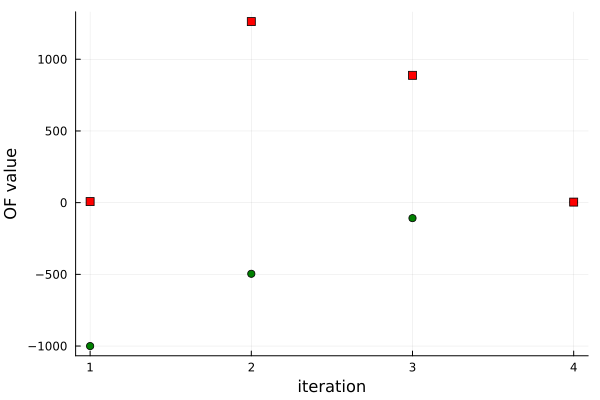

In [10]:
display(p)